# Mini Projet 2024 - à quoi tu ressembles sans ton masque ?

Avec la pandémie de la Covid-19, nous avons appris à porter des masques quotidiennement. 
Désormais la moitié de notre visage est cachée nous laissant le regard pour seul moyen d'expression visible. Cette opération de restaurer le visage s'apparente à un domaine en traitement d'images et de vidéos appelé **inpainting**. En effet, les pixels correspondant à la zone du masque (modélisé par un rectangle) sont mis à 0. Et l'ACP et les **eigenfaces** permettent, entre autres, de restaurer la zone dégradée.  


L'**objectif de ce mini projet** consiste à combler la zone de masque par un visage qui est le plus semblable à l'aide de l'ACP et des $k$ plus proches voisins.

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.neighbors import NearestNeighbors
from random import *

## Chargement des données

La base de données sur laquelle ce projet est appliqué est une collection d'images utiles pour mener des expériences en psychologie (*Psychological Image Collection at Stirling* (PICS) :http://pics.stir.ac.uk). 

<img src="files/base.PNG" width="800" height="600"  >

Elle comporte 32 personnes (16 hommes et 16 femmes) avec 6 postures/expressions  faciales : 2 postures (face et trois quart face) et 3 émotions différentes par posture.



Text(0.5, 1.0, 'Exemple de visage')

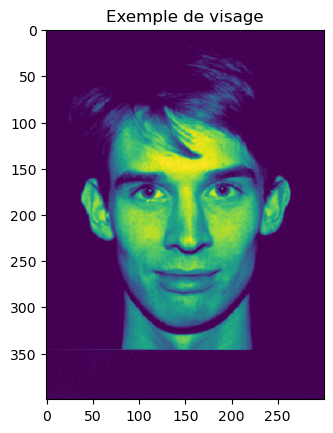

In [ ]:
# Chargement des données de visages entiers : 192 x 120000
X_Data=np.load('Data.npy')

# Dimensions des images
nblignes=400
nb_colonnes=300

plt.imshow(np.reshape(X_Data[0,:],(nblignes,nb_colonnes))) 
plt.title('Exemple de visage')

Text(0.5, 1.0, 'Exemple de visage masqué')

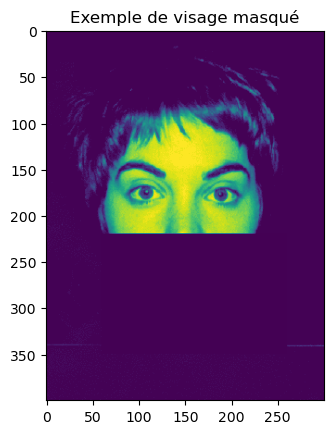

In [3]:
# Chargement des données de visages masqués : 192 x 120000
X_DataMask=np.load('DataMask.npy')

plt.imshow(np.reshape(X_DataMask[0,:],(nblignes,nb_colonnes))) 
plt.title('Exemple de visage masqué')



# Création base d'apprentissage

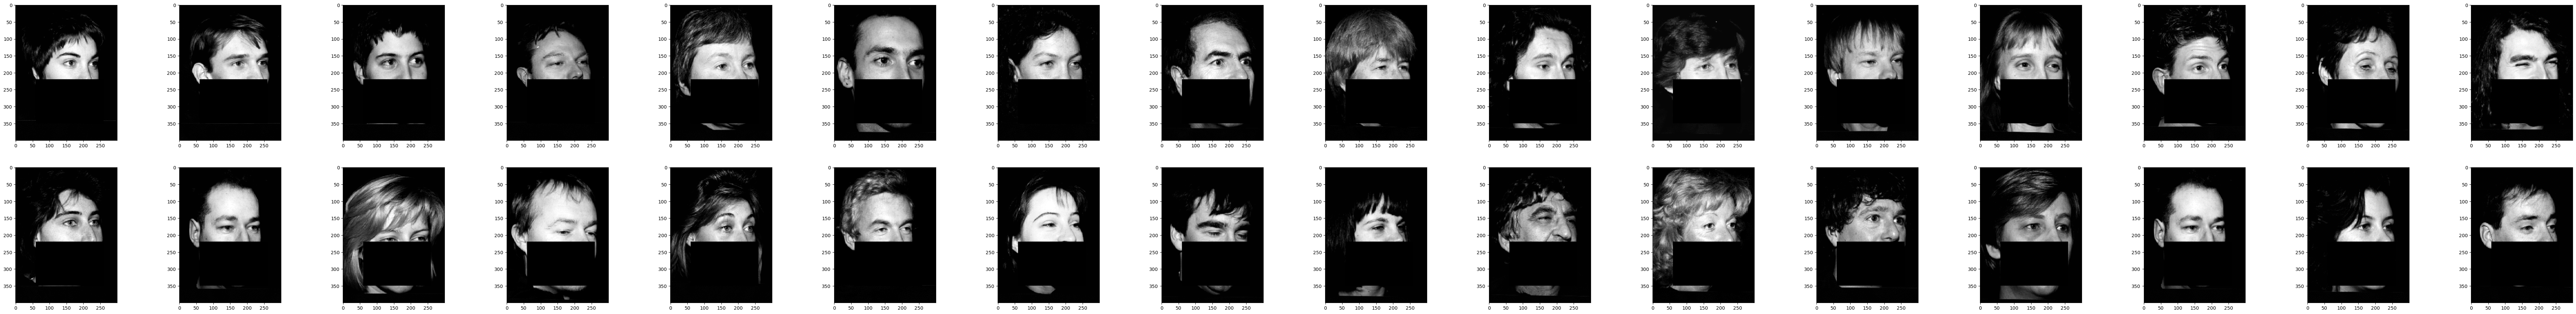

In [ ]:
# Création de la base d'apprentissage : exemple à modifier
X_App = X_DataMask[np.concatenate([np.arange(i, i + 4) for i in range(0, 192, 6)]), :]


Y_App = X_Data[np.concatenate([np.arange(i, i + 4) for i in range(0, 192, 6)]), :]

X_test = X_DataMask[np.concatenate([np.arange(i + 4 + 1, i + 4 + 2) for i in range(0, 192, 6)]), :]

Y_test = X_Data[np.concatenate([np.arange(i + 4 +1, i + 4 + 2) for i in range(0, 192, 6)]), :]

# Affichage des visages masqués de la base d'apprentissage
plt.figure(figsize=(100,100))
compt=0
for i in range(0,X_test.shape[0]):
    im=np.reshape(X_test[i,:],(400,300))
    plt.subplot(16,16,compt+1)
    compt=compt+1
    plt.imshow(im,cmap='gray')
    
plt.show()    




##  Eigenfaces et réduction de dimensions par ACP

Complétez la fonction *eigenfaces*, qui vise à calculer les axes
principaux des images d'apprentissage à partir des vecteurs propres associés
aux $n-1$ valeurs propres non nulles de la matrice de variance/covariance
$\Sigma$ des données/.


La notion d'eigenfaces provient du travail de M. Turk et A. Pentland intitulé «Eigenfaces for
Recognition» : https://www.mitpressjournals.org/doi/pdfplus/10.1162/jocn.1991.3.1.71 


<img src="files/Eigenfaces.PNG" width="600" height="500"  >

**Remarque :**  la
    fonction *np.linalg.eig* ne peut pas être directement appliquée à $\Sigma$. En
    effet, sa taille $p\times p$ est gigantesque ($p = 120000$). Or, pour une
    matrice $\text{M}$ quelconque, $\text{M}^\top \text{M}$ et
    $\text{M}\,\text{M}^\top$ ont les mêmes valeurs propres \emph{non nulles}.
    On peut donc appliquer la fonction \verb!eig! à $\Sigma_2 = \text{X}_c \,
    \text{X}_c^\top/n$, de taille $n\times n$ beaucoup plus petite, pour
    calculer les valeurs propres non nulles de $\Sigma$.

In [33]:
def eigenface(X_App, nb_component):

    mean_image = np.mean(X_App, axis=0)

    X_centered = X_App - mean_image

    n_samples = X_App.shape[0]
    covariance_matrix = np.dot(X_centered, X_centered.T) / n_samples

    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigvals)[::-1]
    top_indices = sorted_indices[:nb_component]
    top_eigvecs = eigvecs[:, top_indices]

    eigenfaces = np.dot(X_centered.T, top_eigvecs)
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0) 

    projections = np.dot(X_centered, eigenfaces)

    return eigenfaces, mean_image, projections

def data_project(X, eigenfaces, mean_image):

    X_centered = X - mean_image
    return np.dot(X_centered, eigenfaces)



## Reconnaissance par kppv

En tirant aléatoirement une image de test, parmi les 32 personnes et les 6 postures faciales disponibles dans la base de données complète, complétez une fonction pour trouver l'individu (personne+posture) et la distance du proche voisin dans la base d'apprentissage qui est le plus proche de l'image de test (vous pouvez utiliser et adapter la fonction \texttt{kppv} que vous avez écrite lors du TP2). 

In [6]:
# à vous
def recognize_with_kppv(X_test, X_App_projections, k):
    neigh = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neigh.fit(X_App_projections)
    distances, indices = neigh.kneighbors(X_test)
    return indices

## Reconstruction 

A partir de la question précédente, implémentez la reconstruction de la zone du masque  en remplaçant la zone correspondant au masque par la zone de l'image de la base d'apprentissage de visages entiers la plus proche dans l'espace défini par les eigenfaces masqués.



In [ ]:
def reconstruct_and_visualize(test_image, nearest_image_original, mask_zone):
    if test_image.ndim == 1:
        test_image = test_image.reshape(400, 300)
    if nearest_image_original.ndim == 1:
        nearest_image_original = nearest_image_original.reshape(400, 300)

    reconstructed_image = test_image.copy()
    reconstructed_image[mask_zone] = nearest_image_original[mask_zone]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(test_image, cmap='gray')
    axes[0].set_title('Image de Test (Avec Masque)')
    axes[0].axis('off')

    axes[1].imshow(nearest_image_original, cmap='gray')
    axes[1].set_title('Image Non Masque la Plus Proche')
    axes[1].axis('off')

    axes[2].imshow(reconstructed_image, cmap='gray')
    axes[2].set_title('Image Reconstruite')
    axes[2].axis('off')

    plt.show()




def pipeline(X_App, X_test, mask_coords, nb_component, k):
 
    eigenfaces, mean_image, X_App_projections = eigenface(X_App, nb_component)

    X_test_projections = data_project(X_test, eigenfaces, mean_image)

    for i, test_image in enumerate(X_test):
        k_indices = recognize_with_kppv(
            X_test_projections[i].reshape(1, -1), X_App_projections, k
        )[0]
        nearest_image = Y_App[k_indices[0]]

        reconstruct_and_visualize(test_image, nearest_image, mask_coords)

X_App = X_DataMask[np.concatenate([np.arange(i, i + 4) for i in range(0, 192, 6)]), :]


ligne_min = 220
ligne_max = 350
colonne_min = 60
colonne_max = 260
mask_coords = (slice(ligne_min, ligne_max), slice(colonne_min, colonne_max))

nb_component = 50  
k = 3

# Exécution du pipeline
pipeline(X_App, X_test, mask_coords, nb_component, k)

# Evaluation

Pour l'évaluation, une possibilité serait d'estimer la distribution des distances au plus proche voisin dans le cas de la même personne avec une émotion différente et une posture différente.

En fonction de cette distribution, on peut définir une distance seuil à partir de laquelle on peut envoyer un message en précisant que 
-la personne la + proche n'est pas la bonne personne associée à l'image requête 

**Autre piste :** Affiner l'étude aussi lorsque la personne idenfiée correspond à l'image requête avec une autre distance spécifique pour une posture différente voire pour une émotion différente ? Plein de possiblités pour cette étude sur l'évaluation de la reconstruction.

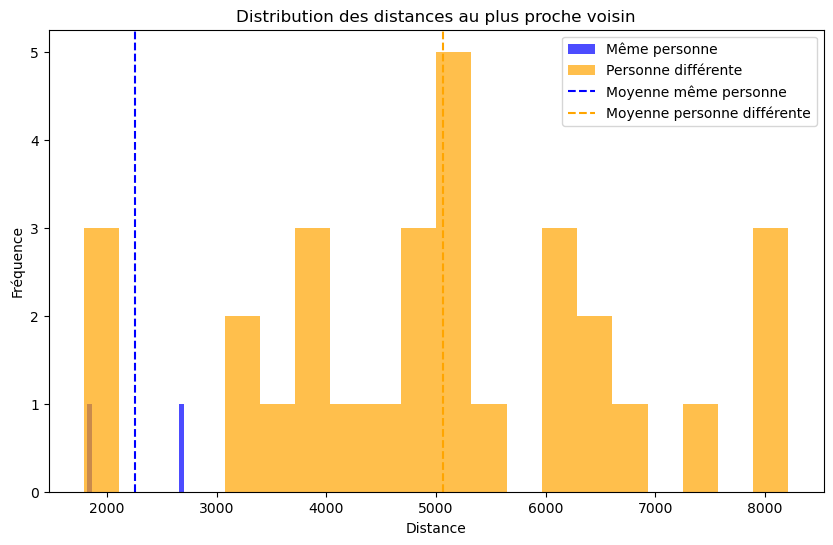

Seuil pour même personne : 2654.40
Seuil pour personne différente : 1904.17
Précision globale : 87.50%


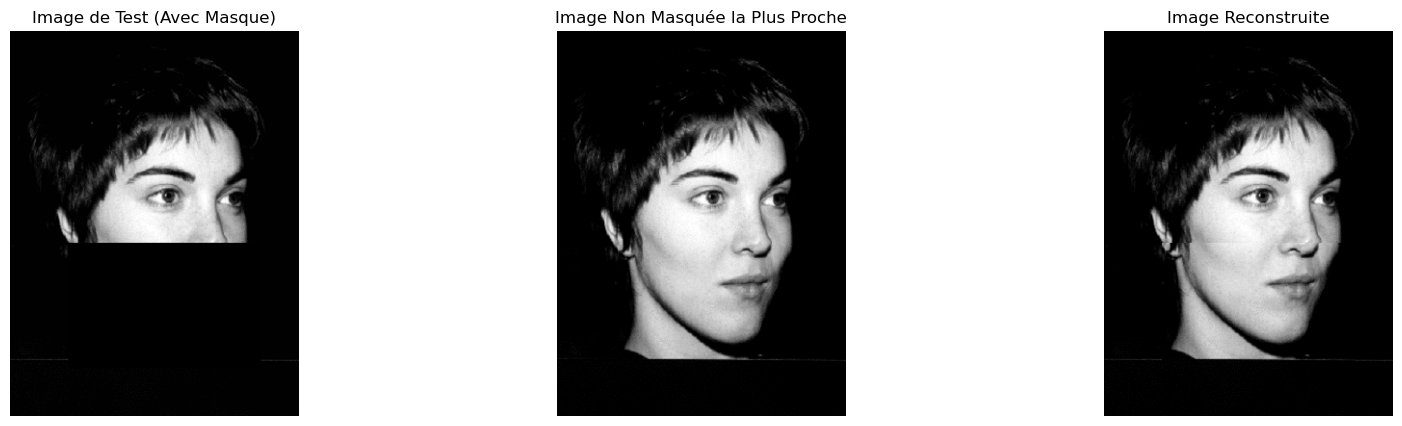

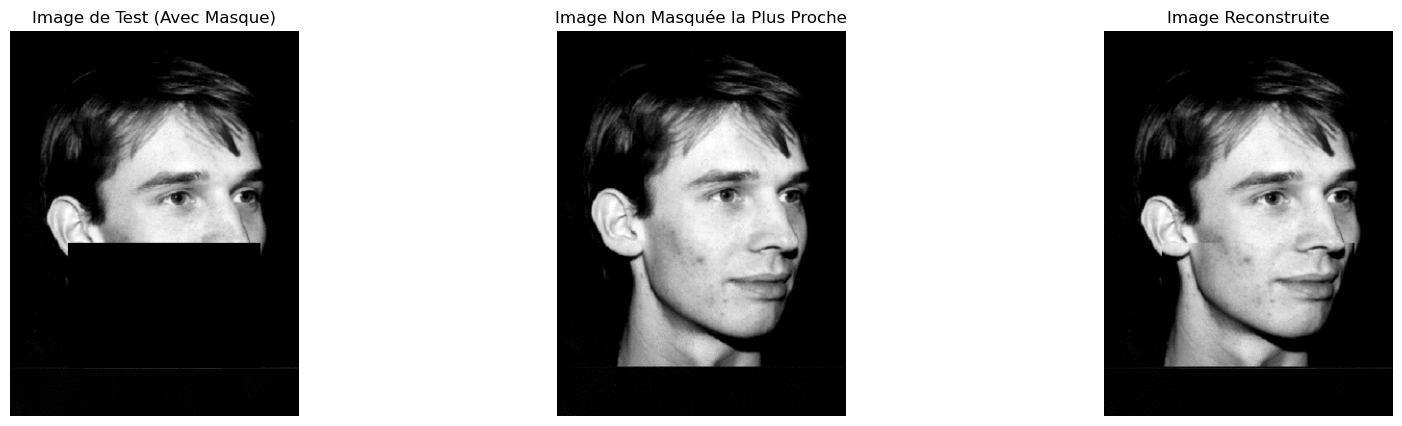

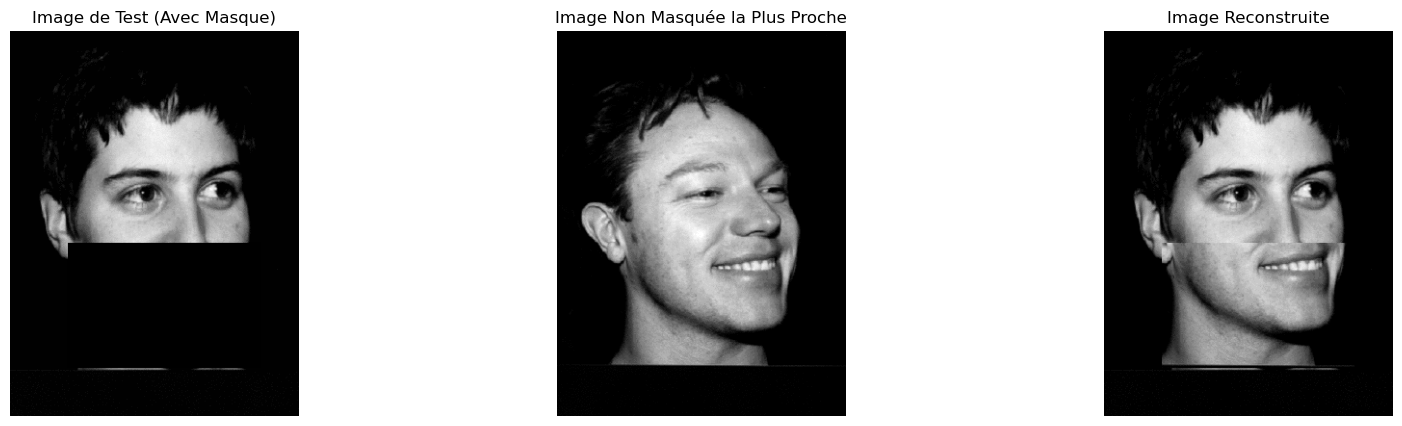

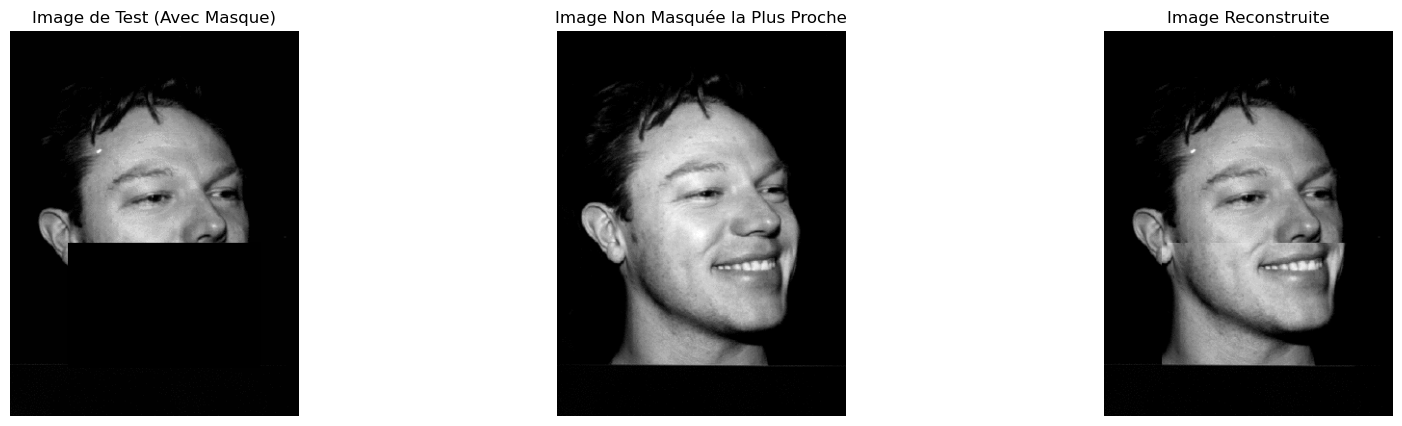

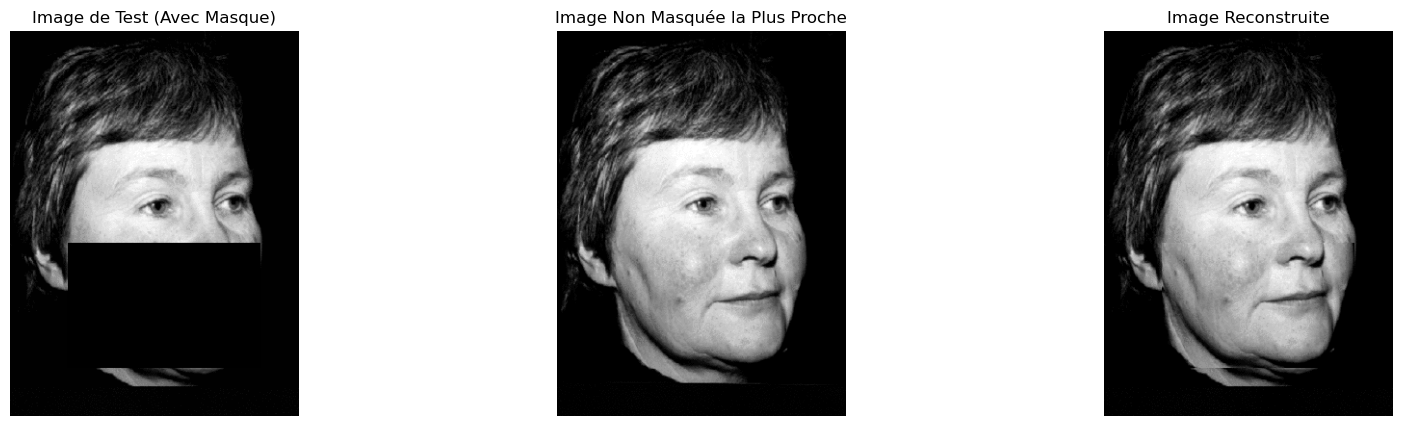

In [47]:
def evaluate_reconstruction(X_App, X_Test, Y_App, Y_Test, eigenfaces, mean_image, k=3):
    # Projections dans l'espace des eigenfaces
    X_App_projections = np.dot(X_App - mean_image, eigenfaces)
    X_Test_projections = np.dot(X_Test - mean_image, eigenfaces)

    # k-Plus Proches Voisins
    neigh = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neigh.fit(X_App_projections)
    distances, indices = neigh.kneighbors(X_Test_projections)

    # Étiquetage des distances
    labels = [1 if i // 6 == idx // 6 else 0 for idx, i in enumerate(indices[:, 0])]
    same_person_distances = [dist for dist, label in zip(distances[:, 0], labels) if label == 1]
    different_person_distances = [dist for dist, label in zip(distances[:, 0], labels) if label == 0]

    # Visualisation des distances
    plt.figure(figsize=(10, 6))
    plt.hist(same_person_distances, bins=20, alpha=0.7, label='Même personne', color='blue')
    plt.hist(different_person_distances, bins=20, alpha=0.7, label='Personne différente', color='orange')
    plt.axvline(x=np.mean(same_person_distances), color='blue', linestyle='--', label='Moyenne même personne')
    plt.axvline(x=np.mean(different_person_distances), color='orange', linestyle='--', label='Moyenne personne différente')
    plt.title('Distribution des distances au plus proche voisin')
    plt.xlabel('Distance')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.show()

    # Calcul des seuils
    seuil_same = np.percentile(same_person_distances, 95)
    seuil_diff = np.percentile(different_person_distances, 5)
    print(f"Seuil pour même personne : {seuil_same:.2f}")
    print(f"Seuil pour personne différente : {seuil_diff:.2f}")

    # Prédictions basées sur les seuils
    predictions = []
    for dist in distances[:, 0]:
        if dist <= seuil_same:
            predictions.append(1)  # Même personne
        elif dist >= seuil_diff:
            predictions.append(0)  # Personne différente
        else:
            predictions.append(-1)  # Zone ambiguë

    # Calcul de la précision
    valid_indices = [i for i, pred in enumerate(predictions) if pred != -1]
    valid_labels = [labels[i] for i in valid_indices]
    valid_predictions = [predictions[i] for i in valid_indices]
    accuracy = np.mean([pred == label for pred, label in zip(valid_predictions, valid_labels)])

    print(f"Précision globale : {accuracy * 100:.2f}%")

    for i in range(5):  
        nearest_index = indices[i, 0]  
        test_image = X_Test[i].reshape(400, 300)  
        true_image = Y_Test[i].reshape(400, 300)  
        nearest_image = Y_App[nearest_index].reshape(400, 300)  

        # Reconstruction
        reconstructed_image = test_image.copy()
        mask_coords = (slice(220, 350), slice(60, 260))
        reconstructed_image[mask_coords] = nearest_image[mask_coords]

        # Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(test_image, cmap='gray')
        axes[0].set_title('Image de Test (Avec Masque)')
        axes[0].axis('off')

        axes[1].imshow(nearest_image, cmap='gray')
        axes[1].set_title('Image Non Masquée la Plus Proche')
        axes[1].axis('off')

        axes[2].imshow(reconstructed_image, cmap='gray')
        axes[2].set_title('Image Reconstruite')
        axes[2].axis('off')


        plt.show()


X_App = X_DataMask[np.concatenate([np.arange(i, i + 4) for i in range(0, 192, 6)]), :]

mean_image = np.mean(X_App, axis=0)
X_App_centered = X_App - mean_image
eigenfaces = np.linalg.svd(X_App_centered.T, full_matrices=False)[0][:, :50]  

evaluate_reconstruction(X_App,X_test,Y_App,Y_test,eigenfaces,mean_image,k=3)
